# Extract Clusters from Python Dendrogram

One aspect of using Python for data analysis is that hierarchical clustering dendrograms are rather cumbersome to work with. Both in terms of plotting next to a heatmap, and how to relate the input data to the resulting plot. Ideally the `dendrogram` function would return a proper instances of some Dendrogram class.

There are plenty ([1](http://nbviewer.ipython.org/github/OxanaSachenkova/hclust-python/blob/master/hclust.ipynb), [2](http://nbviewer.ipython.org/github/herrfz/dataanalysis/blob/master/week3/hierarchical_clustering.ipynb)) of guides around on how to make R inspired heatmaps with dendrograms. Here I will describe how to parse out the cluster members as seen in a dendrogram, which can be handy if one notices interesting patterns in the corresponding heatmap.

Let's start with importing some modules.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [27]:
from collections import defaultdict


# from scipy.cluster.hierarchy import dendrogram, set_link_color_palette
# from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata, leaves_list
# # from fastcluster import linkage
import pandas as pd
import numpy as np
import string as s
import seaborn as sns
import math
# import tables
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style, colors
from itertools import groupby
import matplotlib.patches as patches
from matplotlib import gridspec
import scipy.stats as stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata, leaves_list
from scipy.spatial.distance import pdist
from scipy.ndimage.interpolation import shift
# matplotlib.style.use('ggplot')
# %matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
# matplotlib.rcParams['figure.facecolor'] = 'white'
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets.samples_generator import make_swiss_roll
matplotlib.style.use('ggplot')
%matplotlib inline

from matplotlib.colors import rgb2hex, colorConverter

We also set some prettier non-default colors.

In [6]:
sns.set_palette('Set1', 10, 0.65)
palette = sns.color_palette()
set_link_color_palette(map(rgb2hex, palette))
sns.set_style('white')

TypeError: palette must be a list or tuple

In [34]:
numpy.random.seed(25)

We should create some simple example data for the purpose of illustration.

In [35]:
x, y = 3, 10
df = pd.DataFrame(np.random.randn(x, y),
                  index=['sample_{}'.format(i) for i in range(1, x + 1)],
                  columns=['gene_{}'.format(i) for i in range(1, y + 1)])

In [36]:
link = linkage(df, metric='correlation', method='complete')

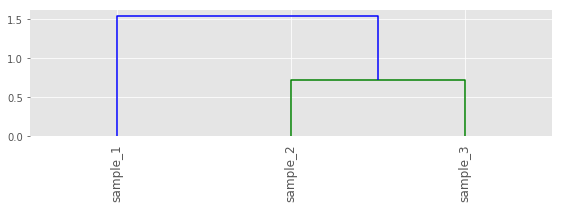

In [37]:
figsize(8, 3)
den = dendrogram(link, labels=df.index)#, abv_threshold_color='#AAAAAA')
plt.xticks(rotation=90)
no_spine = {'left': True, 'bottom': True, 'right': True, 'top': True}
sns.despine(**no_spine);

plt.tight_layout()
plt.savefig('tree1.png');

The dendrogram function will return a dictonary containing a representation of the tree as plotted.

In [13]:
den

{'icoord': [[15.0, 15.0, 25.0, 25.0], [5.0, 5.0, 20.0, 20.0]],
 'dcoord': [[0.0, 0.44024696746449143, 0.44024696746449143, 0.0],
  [0.0, 1.2865846638190943, 1.2865846638190943, 0.44024696746449143]],
 'ivl': ['sample_3', 'sample_1', 'sample_2'],
 'leaves': [2, 0, 1],
 'color_list': ['g', 'b']}

The tree is represented as a collection of ∏ shaped components.

The three items named 'color_list', 'dcoord', 'icoord' indexes these ∏'s

Obviosly 'color\_list' contains the colors. The lists in 'dcoord' contain the y coordinates of the ∏'s (the _distances_) while 'icoord' has the x coordinates. These would be the _index coordinates_.

In the minimal example above we have two ∏'s, and one can see that the x-coordinates are repeated once.

The coordinates go from left to right. So for the red ∏, the 'legs' are located at 15 and 25, while the grey one has legs at 5 and 20.

The apperant pattern is that legs positioned at leaves will end with 5. The reason is to nicely place the leg at the middle of the corresponding leaf index value. This also implies the actual list indices of the leaf are multiplied by 10.

Thus we first subtract 5 from each colors icoord, then divide by 10. If the resulting number is close to the closest integer, we consider this to be an index for a leaf. If the resulting number is not close to an integer index, it means the colored tree we got it from is from non-leaf parts of the trees.

For each leaf, we add it to a list per color in a dictionary.

In [38]:
cluster_idxs = defaultdict(list)
for c, pi in zip(den['color_list'], den['icoord']):
    for leg in pi[1:3]:
        i = (leg - 5.0) / 10.0
        if abs(i - int(i)) < 1e-5:
            cluster_idxs[c].append(int(i))

In [39]:
cluster_idxs

defaultdict(list, {'g': [1, 2], 'b': [0]})

Next we need to grab the labels of the leaves given the indexes. But before we do that, since it's difficult to keep track of what color e.g. '#c13d3f' is, we make make an [IPython notebook compatible HTML representation](http://ipython.org/ipython-doc/dev/config/integrating.html) of the dictionary holding the information. Objects of this class will behave just like dictionaries, except for representing them as a HTML table.

In [40]:
class Clusters(dict):
    def _repr_html_(self):
        html = '<table style="border: 0;">'
        for c in self:
            hx = rgb2hex(colorConverter.to_rgb(c))
            html += '<tr style="border: 0;">' \
            '<td style="background-color: {0}; ' \
                       'border: 0;">' \
            '<code style="background-color: {0};">'.format(hx)
            html += c + '</code></td>'
            html += '<td style="border: 0"><code>' 
            html += repr(self[c]) + '</code>'
            html += '</td></tr>'
        
        html += '</table>'
        
        return html

(Note that the representation uses colerConverter from matplotlib, so it supports any matplotlib supported color representation, not only hex color strings.)

Now just go through the list of indices and fetch labels.

In [41]:
cluster_classes = Clusters()
for c, l in cluster_idxs.items():
    i_l = [den['ivl'][i] for i in l]
    cluster_classes[c] = i_l

In [42]:
cluster_classes

g,"['sample_2', 'sample_3']"
b,['sample_1']


In [43]:
print(cluster_classes._repr_html_())

<table style="border: 0;"><tr style="border: 0;"><td style="background-color: #008000; border: 0;"><code style="background-color: #008000;">g</code></td><td style="border: 0"><code>['sample_2', 'sample_3']</code></td></tr><tr style="border: 0;"><td style="background-color: #0000ff; border: 0;"><code style="background-color: #0000ff;">b</code></td><td style="border: 0"><code>['sample_1']</code></td></tr></table>


Let's combine this to a nice reusable function, and try it out on a larger example.

In [44]:
def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))
    
    cluster_classes = Clusters()
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l
    
    return cluster_classes

In [45]:
x, y = 96, 10
df = pd.DataFrame(np.random.randn(x, y),
                  index=['sample_{}'.format(i) for i in range(1, x + 1)],
                  columns=['gene_{}'.format(i) for i in range(1, y + 1)])

In [46]:
# link = linkage(df, metric='correlation', method='ward')
dist='correlation'
link='ward'
Z = linkage(pdist(df, dist), link)
# aa = dendrogram(Z, leaf_rotation=90.,labels = dfm.columns,leaf_font_size=12.,show_contracted=True)#


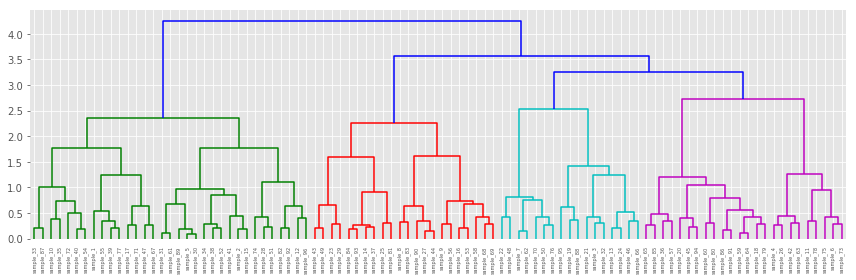

In [47]:
figsize(12, 4)
den = dendrogram(Z, labels=df.index)#, abv_threshold_color='#AAAAAA')
plt.xticks(rotation=90)
sns.despine(**no_spine);

plt.tight_layout()
plt.savefig('tree2.png');

In [48]:
get_cluster_classes(den)

g,"['sample_33', 'sample_87', 'sample_10', 'sample_35', 'sample_40', 'sample_54', 'sample_72', 'sample_39', 'sample_77', 'sample_55', 'sample_1', 'sample_17', 'sample_71', 'sample_47', 'sample_67', 'sample_31', 'sample_61', 'sample_5', 'sample_30', 'sample_89', 'sample_38', 'sample_52', 'sample_34', 'sample_2', 'sample_15', 'sample_41', 'sample_28', 'sample_51', 'sample_74', 'sample_82', 'sample_92', 'sample_12', 'sample_96']"
r,"['sample_43', 'sample_49', 'sample_23', 'sample_29', 'sample_84', 'sample_93', 'sample_14', 'sample_37', 'sample_25', 'sample_81', 'sample_37', 'sample_8', 'sample_83', 'sample_27', 'sample_44', 'sample_90', 'sample_9', 'sample_56', 'sample_16', 'sample_53', 'sample_68', 'sample_69', 'sample_58']"
c,"['sample_22', 'sample_48', 'sample_7', 'sample_62', 'sample_50', 'sample_76', 'sample_70', 'sample_19', 'sample_88', 'sample_95', 'sample_3', 'sample_32', 'sample_21', 'sample_13', 'sample_24', 'sample_46', 'sample_66']"
m,"['sample_65', 'sample_85', 'sample_36', 'sample_57', 'sample_45', 'sample_94', 'sample_20', 'sample_60', 'sample_80', 'sample_86', 'sample_91', 'sample_59', 'sample_64', 'sample_18', 'sample_79', 'sample_59', 'sample_60', 'sample_4', 'sample_26', 'sample_42', 'sample_63', 'sample_11', 'sample_78', 'sample_6', 'sample_73', 'sample_75']"


In [20]:
print(_._repr_html_())

<table style="border: 0;"><tr style="border: 0;"><td style="background-color: #c13d3f; border: 0;"><code style="background-color: #c13d3f;">#c13d3f</code></td><td style="border: 0"><code>['sample_20', 'sample_87', 'sample_35', 'sample_2', 'sample_24', 'sample_13', 'sample_6', 'sample_82', 'sample_11', 'sample_12', 'sample_44', 'sample_94', 'sample_73', 'sample_77', 'sample_76']</code></td></tr><tr style="border: 0;"><td style="background-color: #4e7ca1; border: 0;"><code style="background-color: #4e7ca1;">#4e7ca1</code></td><td style="border: 0"><code>['sample_56', 'sample_81', 'sample_69', 'sample_9', 'sample_27', 'sample_21', 'sample_45', 'sample_52', 'sample_59', 'sample_46', 'sample_93', 'sample_10', 'sample_48', 'sample_78', 'sample_14', 'sample_50', 'sample_31', 'sample_91', 'sample_75', 'sample_86', 'sample_84', 'sample_55', 'sample_88', 'sample_43', 'sample_58', 'sample_33', 'sample_96', 'sample_34', 'sample_19', 'sample_68', 'sample_21']</code></td></tr><tr style="border: 0;">